In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
def count_turns(labyrinth):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Rechts, Unten, Links, Oben
    num_turns = 0

    for i in range(1, labyrinth.shape[0] - 1):
        for j in range(1, labyrinth.shape[1] - 1):
            if labyrinth[i, j] == 1:
                valid_neighbors = 0
                for dx, dy in directions:
                    ni, nj = i + dx, j + dy
                    if labyrinth[ni, nj] == 1:
                        valid_neighbors += 1
                if valid_neighbors == 2:  # Zwei gültige Nachbarn bedeuten eine Richtungsänderung
                    num_turns += 1

    return num_turns

In [ ]:

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_bert.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_229999_bert.pt' 


path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-30' # 2
config_name = 'config_001_lastunet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_399999_lastunet.pt'


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-28' # 2
config_name = 'config_001_hollowelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_259999_hollowelbo.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt'

path = "SavedModels/Synthetic/"
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_hollowCEProb500K.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2024-01-05' # 2
config_name = 'config_001_hollowdirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollowdirect.pt' 

path = "SavedModels/SyntheticMasked/"
date = '2023-12-17' # 2
config_name = 'config_001_maskeddirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_maskeddirect.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' 

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [ ]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'CRMTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 10
cfg.sampler.is_ordinal = False
#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
model = model.float()
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()


In [ ]:
"""
s_name = 'masked_direct_CRMLBJF1000_synthetic.npy'
saving_plot_path = 'masked_direct_CRMLBJF1000_synthetic'
samples = np.load(s_name)


bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)

samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)


#saving_plot_path = os.path.join(path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
#saving_np_path = os.path.join(path, f"samples_{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.npy")
#np.save(f'{saving_np_path}', samples)

#aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")
"""

In [ ]:
"""
n_samples = 10*15
#s_name = 'Samples/mnist_unet_LBJF2000.npy'
# hollow_{cfg.sampler.name}{cfg.sampler.num_steps}_mazes
s_name = 'Samples/unet_LBJF750_mazes.npy'
samples = np.load(s_name)
samples = samples.reshape(-1, 1, 15, 15)
#saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(10, 15)) 
plt.subplots_adjust(wspace=0.001, hspace=0.001)
int(np.sqrt(n_samples))
for i in range(n_samples):
    plt.subplot(int(15), int(10), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

plt.tight_layout()  
plt.savefig('unet_LBJF750_mazes.png', transparent=True)
plt.show()
plt.close()
"""

In [ ]:
n_samples = 2500 #cfg.data.batch_size 
samples, changes = sampler.sample(model, n_samples)
print(changes)
print(np.mean(changes))
saved_samples = samples

In [ ]:
"""
samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
n_samples2 = 100
saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(9, 9)) 
for i in range(n_samples2):
    plt.subplot(int(np.sqrt(n_samples2)), int(np.sqrt(n_samples2)), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")


#plt.savefig(saving_train_path)
plt.show()
plt.close()
"""

In [ ]:
correct_mazes = maze_acc(saved_samples)

In [ ]:
cfg.data.name = 'Maze3SComplete'
cfg.data.batch_size = n_samples

if cfg.data.name == 'Maze3SComplete':
    limit = cfg.data.batch_size
    cfg.data.limit = limit 

dataset = dataset_utils.get_dataset(cfg, device)
dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i in dataloader:
    true_dl = i
    c_i = maze_acc(i.cpu().numpy())
    true_dl = true_dl.reshape(cfg.data.batch_size, -1).flatten()

In [ ]:
samples = samples.reshape(cfg.data.batch_size, -1).flatten()
from scipy.stats import wasserstein_distance
print("EMD", wasserstein_distance(samples, true_dl.cpu().numpy()))


# only EMD: 5000
# Unet:
# TauL: 0.02457 40 %
# LBJF: 0.023745777777777866 45%
# MPTauL:

# Hollow:
# LBJF: 0.0011570370370370675 85%
# TauL: 0.005959999999999965 83%
# Analytical: 0.006370370370369915 83.5%

# Hollow Elbo:
# Analytical: 0.002561481481481387 62% # 
# LBJF: # 0.00424 63%
# TauL: 0.0092 63%

# 30: 0.000552592592592438

# 250 bei TauL nochmal oder 500

# ExactSampling: 1500: 85% and EMD  1.22
# LBJF: 93% 1.04

# Excplicit Hollow:
# LBJF: 18% EMD 0.005293333333333261
# TauL: 19 % EMD 0.011789629629629594

# Hollow-Transformer:
# 1 Step:
# LBJF: acc 0 und EMD 2: 0 und 0.0470.29 5: 9% 0.009 0.005 0.007: 10: 57, 0.006 0.0053
# TauL: 1: 0 0.2924 2: 0 und 0.196 5: 0 und 0.096
# Exact: 5: 16.5 16.5 % 0.014 0.0155 10: 55% 0.05 0.07

# LBJF: 5: 0.0051 9% 10: 0.00321 60%
# Analy: 5 0.11 15% 10: 0.0051 55%
# TauL: 5: 110 10: 0.036

In [5]:
emd_lbjf = np.array([8, 5.1, 3.38, 2.97, 2.35, 2.12, 1.75, 1.15]) 
emd_anal = np.array([12, 5.0, 3.54, 3.24, 2.92, 2.65, 1.19, 1.16]) 
emd_taul = np.array([110, 63.58, 36.05, 27.64, 17.66, 12.47, 5.96, 2.28]) 

In [6]:
steps = np.array([5, 10, 20, 30, 50, 100, 250, 500] )
acc_lbjf = np.array([9, 60, 75, 80, 82, 84, 85, 88] ) / 100
acc_anal = np.array([16, 55, 75, 78, 82, 83, 83, 85]) / 100
acc_taul = np.array([0, 3, 30, 50, 73, 80, 82, 84]) / 100
rej_rate = np.array([0.372, 0.1662, 0.0732, 0.0434, 0.0243, 0.0115, 0.003, 0.00084])
#20: 0.07 30: 50: 0.0434, 0.024, 0.0

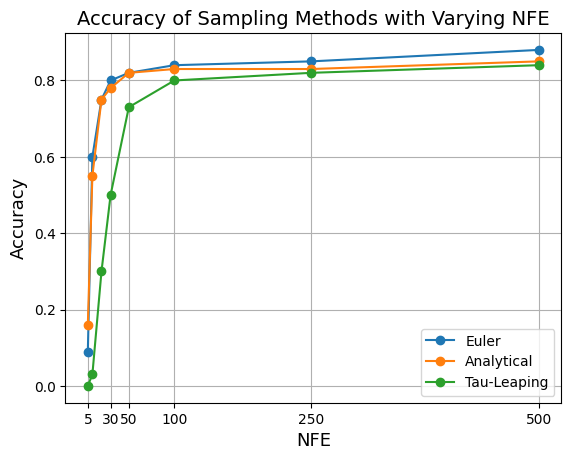

In [7]:
steps_plot = np.array([5, 30, 50, 100, 250, 500] )
plt.plot(steps, acc_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, acc_anal, label='Analytical', marker='o')
plt.plot(steps, acc_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('accuracy_plot.pdf')
plt.show()

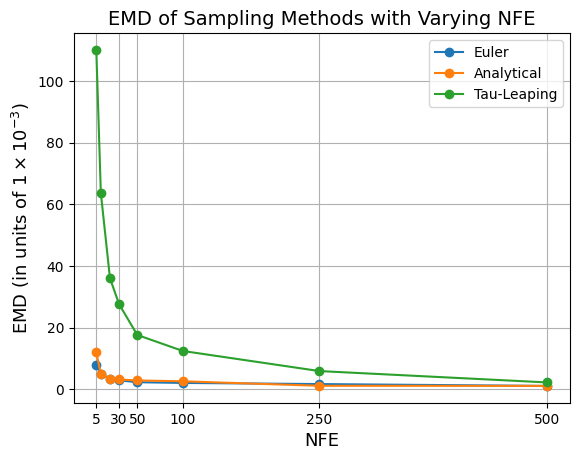

In [8]:
plt.plot(steps, emd_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, emd_anal, label='Analytical', marker='o')
plt.plot(steps, emd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('EMD (in units of $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
steps_plot = np.array([5, 30, 50, 100, 250, 500] )
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot.pdf')
plt.show()

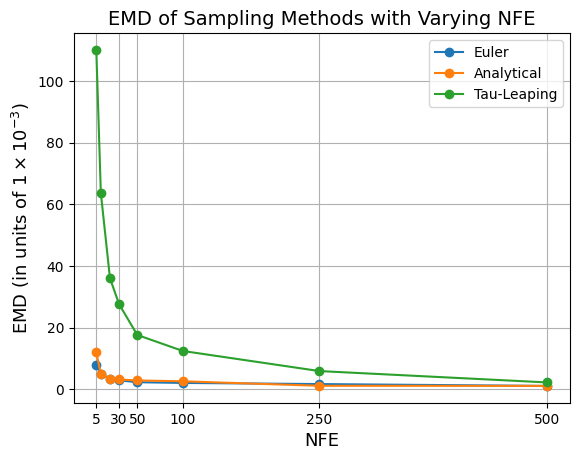

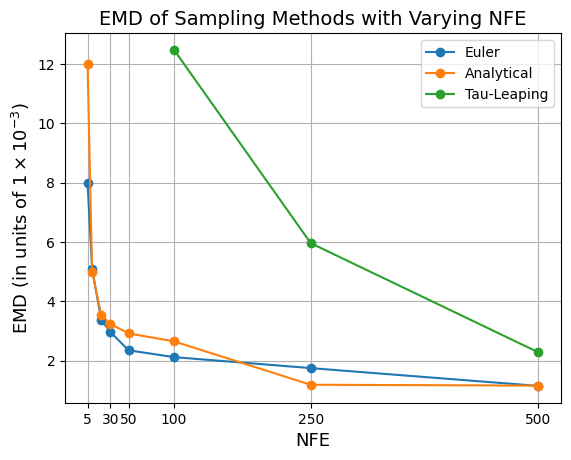

In [10]:
steps = np.array([5, 10, 20, 30, 50, 100, 250, 500] )
emd_lbjf = np.array([8, 5.1, 3.38, 2.97, 2.35, 2.12, 1.75, 1.15]) 
emd_anal = np.array([12, 5.0, 3.54, 3.24, 2.92, 2.65, 1.19, 1.16]) 
emd_taul = np.array([110, 63.58, 36.05, 27.64, 17.66, 12.47, 5.96, 2.28]) 
plt.plot(steps, emd_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, emd_anal, label='Analytical', marker='o')
plt.plot(steps, emd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('EMD (in units of $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
steps_plot = np.array([5, 30, 50, 100, 250, 500] )
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot_first.pdf')
plt.show()

plt.plot(steps, emd_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, emd_anal, label='Analytical', marker='o')
plt.plot(np.array([100, 250, 500]), np.array([12.47, 5.96, 2.28]), label='Tau-Leaping', marker='o')
#plt.plot(steps, emd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('EMD (in units of $1\\times 10^{-3}$)', fontsize=13) 
plt.title('EMD of Sampling Methods with Varying NFE', fontsize=14)
plt.legend()
steps_plot = np.array([5, 30, 50, 100, 250, 500] )
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('emd_plot_last.pdf')
plt.show()

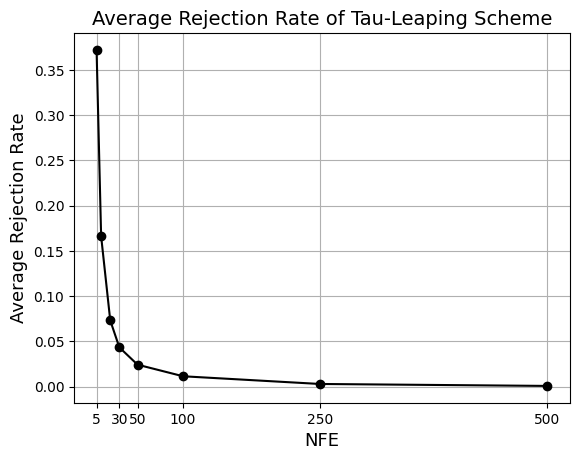

In [11]:

steps_plot = np.array([5, 30, 50, 100, 250, 500] )
plt.plot(steps, rej_rate, marker='o', color='black')
plt.ylabel('Average Rejection Rate', fontsize=13)
plt.xlabel('NFE', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_plot.pdf')
plt.show()

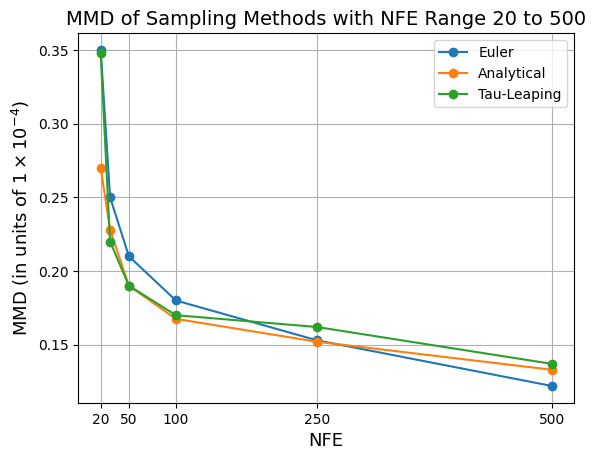

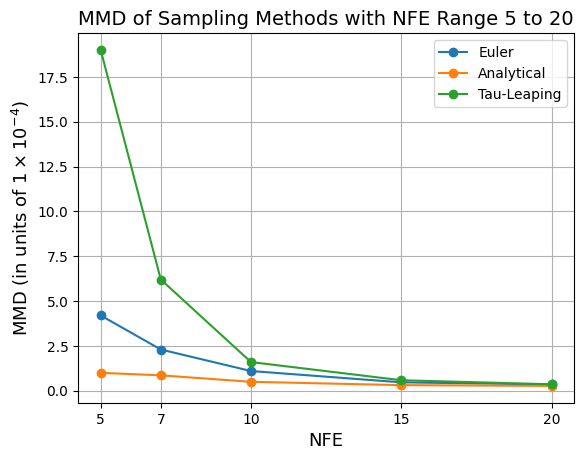

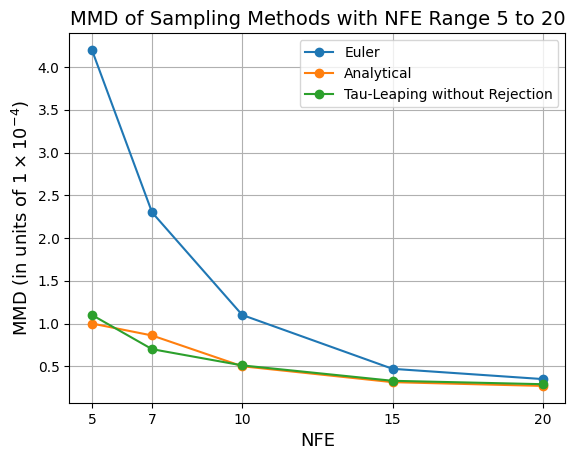

In [13]:
import numpy as np
import matplotlib.pyplot as plt
steps = np.array([20, 30, 50, 100, 250, 500])
mmd_lbjf = np.array([0.35, 0.25, 0.21, 0.18, 0.153, 0.122])
mmd_taul = np.array([0.348, 0.22, 0.19, 0.17, 0.162, 0.137])
mmd_exact = np.array([0.27, 0.228, 0.19, 0.1675, 0.152, 0.133])
steps_plot = np.array([20, 50, 100, 250, 500])
plt.plot(steps, mmd_lbjf , label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, mmd_exact, label='Analytical', marker='o')
plt.plot(steps, mmd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('MMD (in units of $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods with NFE Range 20 to 500', fontsize=14)
plt.legend()
plt.xticks(steps_plot, steps_plot)
plt.grid(True)
plt.savefig('mmd_plot_last.pdf')
plt.show()

steps = np.array([5, 7, 10, 15, 20])
mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.36])
mmd_exact = np.array([1.0, 0.86, 0.5, 0.314, 0.27])
plt.plot(steps, mmd_lbjf , label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, mmd_exact, label='Analytical', marker='o')
plt.plot(steps, mmd_taul, label='Tau-Leaping', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('MMD (in units of $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods with NFE Range 5 to 20', fontsize=14)
plt.legend()
plt.xticks(steps, steps)
plt.grid(True)
plt.savefig('mmd_plot_first20.pdf')
plt.show()

steps = np.array([5, 7, 10, 15, 20])
mmd_lbjf = np.array([4.2, 2.3, 1.1, 0.47 ,0.35])
mmd_taul = np.array([19, 6.2, 1.6, 0.587, 0.36])
mmd_exact = np.array([1.0, 0.86, 0.5, 0.314, 0.27])
mmd_taul_wo = np.array([1.1, 0.7, 0.51, 0.33, 0.29])

plt.plot(steps, mmd_lbjf , label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, mmd_exact, label='Analytical', marker='o')
#plt.plot(steps, mmd_taul, label='Tau-Leaping with Rejection', marker='o')
plt.plot(steps, mmd_taul_wo, label='Tau-Leaping without Rejection', marker='o')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('MMD (in units of $1\\times 10^{-4}$)', fontsize=13) 
plt.title('MMD of Sampling Methods with NFE Range 5 to 20', fontsize=14)
plt.legend()
plt.xticks(steps, steps)
plt.grid(True)
plt.savefig('mmd_plot_first20_worejection.pdf')
plt.show()

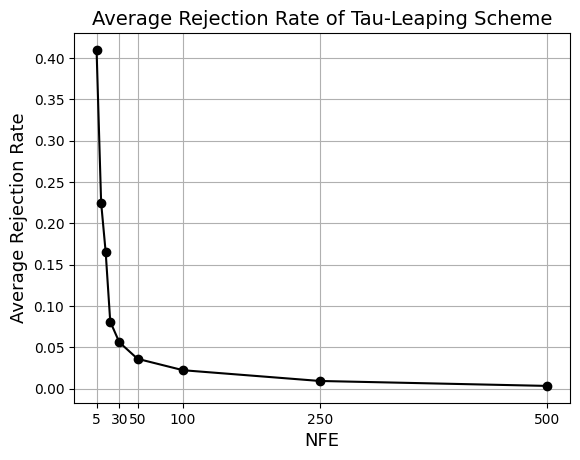

In [15]:
import numpy as np
import matplotlib.pyplot as plt
steps_plot = np.array([5, 30, 50, 100, 250, 500] )
steps = np.array([5, 10, 15, 20, 30, 50, 100, 250, 500])
rej_rate_synthetic = np.array([0.24, 0.116, 0.075, 0.0554, 0.036, 0.021, 0.0094, 0.0019, 0.00039])
avg_ch_dim = np.array([0.41, 0.225, 0.165, 0.081, 0.056, 0.036, 0.0222, 0.0092, 0.0032]) 
plt.plot(steps, avg_ch_dim, marker='o', color='black')
plt.ylabel('Average Rejection Rate', fontsize=13)
plt.xlabel('NFE', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.xticks(steps_plot, steps_plot)
plt.savefig('rej_rate_synthetic_plot.pdf')
plt.show()

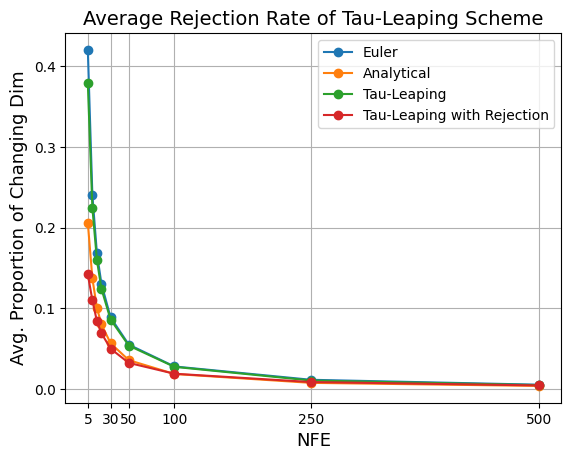

In [16]:
steps = np.array([5, 10,15, 20, 30, 50, 100, 250, 500]) 
change_taul_ord = np.array([0.3787, 0.2247, 0.1595, 0.1239, 0.0861, 0.0538, 0.02755, 0.0106, 0.0049])
clamp_taul_ord = np.array([0.238, 0.1153, 0.075, 0.0552 ,0.036,0.021, 0.00936,0.00192,0.000384])
change_taul_nonord = np.array([0.142, 0.11, 0.0840, 0.069, 0.05, 0.0324, 0.019, 0.0087,0.0045])
change_lbjf = np.array([0.42, 0.24, 0.168, 0.13, 0.0887, 0.055, 0.028, 0.0115, 0.0054])
change_exact = np.array([0.206, 0.137,0.1006,0.08, 0.0567, 0.0358, 0.0187,0.0077,0.0039])

plt.plot(steps, change_lbjf, label='Euler', marker='o') # 'o' für Kreise
plt.plot(steps, change_exact, label='Analytical', marker='o')
plt.plot(steps, change_taul_ord , label='Tau-Leaping', marker='o')
plt.plot(steps, change_taul_nonord , label='Tau-Leaping with Rejection', marker='o')
plt.ylabel('Avg. Proportion of Changing Dim', fontsize=13)
plt.xlabel('NFE', fontsize=13)
plt.title('Average Rejection Rate of Tau-Leaping Scheme', fontsize=14)
plt.grid(True)
plt.legend()
plt.xticks(steps_plot, steps_plot)
plt.show()

In [ ]:
change_taul_nonord_time = [0.0, 0.2691875100135803, 0.21253125369548798, 0.16771875321865082, 0.13959375023841858, 0.11800000816583633, 0.08646875619888306, 0.05946875363588333, 0.036781251430511475, 0.001500000013038516]
change_taul_ord_time = [1.0, 0.3410625159740448, 0.24518750607967377, 0.1925000101327896, 0.15309375524520874, 0.11903125792741776, 0.09334375709295273, 0.06428125500679016, 0.038750000298023224, 0.00043750001350417733]


steps = np.linspace(1, 0, len(change_taul_nonord_time))
plt.gca().invert_xaxis()
plt.plot(steps, change_taul_nonord_time, label='Tau-Leaping Rejection', color='purple')
plt.plot(steps, change_taul_ord_time, label='Tau-Leaping', color='green')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Avg. Proportion of Changing Dimensions', fontsize=13)
plt.legend()
plt.grid(True)
plt.title('Avg. Proportion of Changing Dimension')
#plt.savefig('PNGs/changing_dim_maze50_ordinal.png')
plt.show()
